# Food Classification Analysis


## 1. Setup and Imports


In [1]:
# Standard library
import os
from typing import Any
import shutil
import sys

# Third-party libraries
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import seaborn as sns

# Local libraries
from util import print_col

# Plot styles
plt.rcdefaults()
plt.style.use("seaborn-v0_8-colorblind")
sns.set_palette("colorblind")

# Version info
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"PyArrow version:", pa.__version__)
print(f"Pandas version: {pd.__version__}")
print(f"Dask version: {dask.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")


Python version: 3.12.11 (main, Jun  3 2025, 15:41:47) [Clang 17.0.0 (clang-1700.0.13.3)]
NumPy version: 1.26.4
PyArrow version: 21.0.0
Pandas version: 2.3.2
Dask version: 2025.7.0
Matplotlib version: 3.10.5
Seaborn version: 0.13.2


## 2. Data Loading


Load the dataset using Dask.


In [2]:
df = dd.read_parquet("../eda/food.parquet", engine="pyarrow", dtype_backend="pyarrow")


Based on our EDA findings, the ingredients column is very large; therefore, we will drop it in this full data analysis.


In [3]:
df = df.drop(columns="ingredients")


Print the dataset shape.


In [4]:
df_shape = df.shape[0].compute(), df.shape[1]
print(f"Dataset shape: {df_shape}")
print(f"Total cells: {df_shape[0] * df_shape[1]:,}")


Dataset shape: (3919113, 109)
Total cells: 427,183,317


Load the `data/column_analysis` dataset.


In [5]:
column_analysis_df = pd.read_csv("data/column_analysis.csv")
print(f"Dataset shape: {column_analysis_df.shape}")


Dataset shape: (109, 6)


Print the columns from `identifiers` category.


In [6]:
print(f"Category: \033[94midentifiers\033[0m\n")
for i, row in enumerate(column_analysis_df[column_analysis_df["category"] == "identifiers"].itertuples(index=False), start=1):
    print_col(i, row.column_name, sample=row.sample)


Category: identifiers

  1. code                                     | 0000101209159
  2. emb_codes_tags                           | []
  3. emb_codes                                | nan
  4. generic_name                             | []
  5. images                                   | [{'key': 'front_fr', 'imgid': 1, 'rev': 4, 'sizes': {'100': {'h': 100, 'w': 75},...
  6. link                                     | nan
  7. max_imgid                                | 3
  8. product_name                             | [{'lang': 'main', 'text': 'Véritable pâte à tartiner noisettes chocolat noir'}, ...


Print the columns from `categories` category.


In [7]:
print(f"Category: \033[94mcategories\033[0m\n")
for i, row in enumerate(column_analysis_df[column_analysis_df["category"] == "categories"].itertuples(index=False), start=1):
    print_col(i, row.column_name, sample=row.sample)


Category: categories

  1. categories                               | Petit-déjeuners,Produits à tartiner,Produits à tartiner sucrés,Pâtes à tartiner,...
  2. categories_tags                          | ['en:breakfasts', 'en:spreads', 'en:sweet-spreads', 'fr:pates-a-tartiner', 'en:h...
  3. categories_properties                    | {'ciqual_food_code': 31032, 'agribalyse_food_code': 31032, 'agribalyse_proxy_foo...
  4. ciqual_food_name_tags                    | ['chocolate-spread-with-hazelnuts']
  5. compared_to_category                     | en:cocoa-and-hazelnuts-spreads
  6. food_groups_tags                         | ['en:sugary-snacks', 'en:sweets']


## 3. Category Data Extraction


Extract product categories and save into `data/category_extract`.


In [8]:
def get_main_product_info(code: str, product_infos: list[dict[str, str]]) -> dict[str, str]:
    for product_info in product_infos:
        if product_info["lang"] == "main":
            return product_info
    if len(product_infos) > 0:
        return product_infos[0]
    raise Exception(f"Error parsing product, code: {code} - {product_infos}")

def get_image_metadata(images: Any) -> tuple[str | None, str | None]:
    """Return the primary image key and revision if available."""
    if images is None or images is pd.NA:
        return None, None

    def to_native(value: Any) -> Any:
        for attr in ("as_py", "to_pylist", "to_pydict"):
            method = getattr(value, attr, None)
            if callable(method):
                try:
                    return method()
                except TypeError:
                    continue
        return value

    images_native = to_native(images)

    if isinstance(images_native, dict):
        candidates = images_native.values()
    elif isinstance(images_native, list):
        candidates = images_native
    else:
        return None, None

    for candidate in candidates:
        candidate_dict = to_native(candidate)
        if not isinstance(candidate_dict, dict):
            continue
        image_key = (
            candidate_dict.get("key")
            or candidate_dict.get("name")
            or candidate_dict.get("id")
            or candidate_dict.get("image")
        )
        image_rev = candidate_dict.get("rev")
        if image_key is None or image_rev is None:
            continue
        image_key_str = str(image_key)
        if image_key_str.startswith("front_"):
            return image_key_str, str(image_rev)

    return None, None


def extract_product_categories(df: pd.DataFrame) -> pd.DataFrame:
    """Collect normalized product metadata for category analysis."""
    records = []
    for code, product_infos, categories, images in zip(
        df["code"],
        df["product_name"],
        df["categories"],
        df["images"],
    ):
        if len(product_infos) == 0:
            continue
        if categories is pd.NA:
            continue
        image_key, image_rev = get_image_metadata(images)
        if image_key is None or image_rev is None:
            continue
        product_info = get_main_product_info(code, product_infos)
        records.append({
            "code": code,
            "product_lang": product_info["lang"],
            "product_name": product_info["text"],
            "image_key": image_key,
            "image_rev": image_rev,
            "categories": categories,
        })
    return pd.DataFrame(records)


parts = df[["code", "product_name", "categories", "images"]].map_partitions(
    extract_product_categories,
    meta=pd.DataFrame({
        "code": pd.Series(dtype="str"),
        "product_lang": pd.Series(dtype="str"),
        "product_name": pd.Series(dtype="str"),
        "image_key": pd.Series(dtype="str"),
        "image_rev": pd.Series(dtype="str"),
        "categories": pd.Series(dtype="str"),
    }),
)

with ProgressBar():
    parts.to_parquet("data/category_extract", engine="pyarrow", write_index=False, overwrite=True)


[########################################] | 100% Completed | 203.45 s


Load the `data/nutrient_extract` dataset.


In [9]:
category_extract_df = dd.read_parquet("data/category_extract", engine="pyarrow", dtype_backend="pyarrow")


In [10]:
category_extract_df.head(3)


,code,product_lang,product_name,image_key,image_rev,categories
0,0000101209159,main,Véritable pâte à tartiner noisettes chocolat noir,front_fr,4,"Petit-déjeuners,Produits à tartiner,Produits à..."
1,0000140323687,main,Madeleine Framboise,front_fr,4,"Snacks, Snacks sucrés, Biscuits et gâteaux, Gâ..."
2,0000141013129,main,Croissants margarine,front_fr,4,"Snacks,Snacks sucrés,en:Sweet pastries and pie..."


## 4. Meal Type Classification


Classify food products into meal types based on keywords in product names and categories.


In [11]:
# Define meal type classification rules
MEAL_TYPE_KEYWORDS = {
    "breakfast": [
        "breakfast", "cereal", "muesli", "granola", "oatmeal", "porridge",
        "pancake", "waffle", "toast", "jam", "marmalade", "honey",
        "coffee", "tea", "juice", "smoothie", "yogurt", "yoghurt", "milk",
        "cheese", "croissant", "bagel", "muffin", "egg", "bacon", "butter",
        "cream", "apple", "banana", "oats"
    ],
    "main_meal": [
        "lunch", "dinner", "sandwich", "wrap", "salad", "soup", "pasta", "rice",
        "pizza", "burger", "hot dog", "noodle", "ramen", "sushi", "quinoa",
        "bread", "taco", "burrito", "panini", "kebab", "meat", "chicken",
        "beef", "pork", "fish", "seafood", "steak", "roast", "casserole",
        "stew", "curry", "risotto", "turkey", "salmon", "lasagna", "spaghetti",
        "grill", "barbecue", "tuna", "ready meal", "frozen meal", "tomato",
        "carrot"
    ],
    "snack": [
        "cracker", "nut", "popcorn", "pretzel", "chip", "crisp", "bar",
        "cookie", "biscuit", "chocolate", "candy", "granola bar", "trail mix",
        "fruit snack", "snack", "apple", "banana", "oats"
    ],
    "dessert": [
        "dessert", "cake", "pie", "tart", "ice cream", "gelato", "sorbet",
        "pudding", "mousse", "tiramisu", "brownie", "donut", "doughnut",
        "jam", "honey", "cupcake", "macaron", "eclair", "cream", "butter"
    ],
    "beverage": [
        "cola", "spirit", "liquor", "milk", "shake", "water", "soda",
        "beer", "wine", "smoothie", "coffee", "tea", "latte", "espresso",
        "mocha", "cocktail", "drink", "energy drink", "sparkling water",
        "liqueur"
    ]
}

def classify_meal_type(row: pd.Series) -> list[str]:
    text_to_analyse = f"{row['product_name'].lower()} {row['categories'].lower()}"

    meal_types = []

    for meal_type, keywords in MEAL_TYPE_KEYWORDS.items():
        if any(keyword in text_to_analyse for keyword in keywords):
            meal_types.append(meal_type)

    return meal_types if meal_types else ["unclassified"]

food_category_df = category_extract_df.copy()
food_category_df["meal_types"] = food_category_df.apply(classify_meal_type, axis=1, meta=(None, "object"))


Explode `meal_types` column and compute value counts for meal type distribution.


In [12]:
exploded_meal_types = food_category_df.explode("meal_types")

with ProgressBar():
    meal_type_counts = exploded_meal_types["meal_types"].value_counts().compute()


[########################################] | 100% Completed | 73.95 ss


Generate a pie chart to visualise the distribution of meal types.


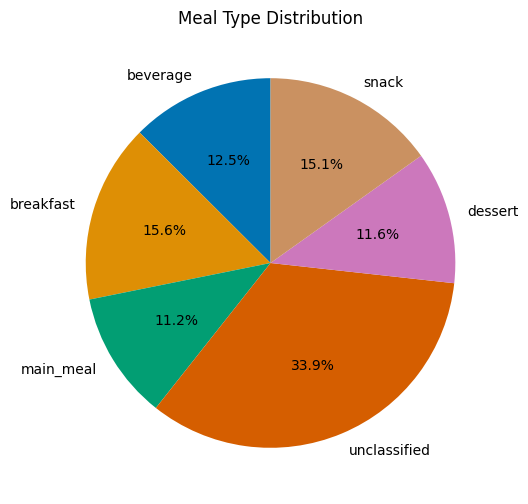

In [13]:
# Labels and sizes for the pie chart
labels = meal_type_counts.index.tolist()
sizes = meal_type_counts.values

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, startangle=90, autopct='%1.1f%%')
plt.title("Meal Type Distribution")
plt.show()


## 5. Category Hierarchy Mapping


Classify food products into category hierarchies based on keywords in product names and categories.


In [14]:
# Define category hierarchy mapping rules
CATEGORY_HIERARCHY = {
    "dairy": [
        "dairy", "milk", "cheese", "yogurt", "yoghurt", "butter", "cream",
        "ghee", "paneer"
    ],
    "meat_fish": [
        "meat", "fish", "seafood", "chicken", "beef", "pork", "turkey",
        "salmon", "tuna", "lamb", "mutton", "duck", "crab", "shrimp",
        "lobster", "cod", "trout", "steak", "roast", "curry", "grill",
        "barbecue"
    ],
    "grains_cereals": [
        "cereal", "bread", "pasta", "rice", "flour", "oats", "wheat",
        "quinoa", "granola", "oatmeal", "barley", "corn", "maize", "rye",
        "millet", "toast", "pancake", "waffle", "muesli", "porridge"
    ],
    "fruits_vegetables": [
        "fruit", "vegetable", "apple", "banana", "tomato", "carrot",
        "spinach", "orange", "grape", "berry", "lettuce", "cucumber",
        "potato", "onion", "pepper", "broccoli"
    ],
    "condiments_spices": [
        "sauce", "spice", "herb", "salt", "pepper", "oil", "vinegar",
        "dressing", "jam", "honey", "ketchup", "mustard", "mayonnaise",
        "chutney", "soy sauce", "hot sauce", "garlic", "ginger"
    ],
    "prepared_meals": [
        "prepared meal", "ready meal", "frozen meal", "pizza", "sandwich",
        "burger", "wrap", "soup", "lasagna", "pasta bake", "stew",
        "casserole", "burrito", "taco", "hot dog", "noodle", "ramen",
        "sushi", "panini", "kebab"
    ]
}

def classify_hierarchy(row: pd.Series) -> list[str]:
    text_to_analyse = f"{row['product_name'].lower()} {row['categories'].lower()}"

    mapped_groups = []

    for group, keywords in CATEGORY_HIERARCHY.items():
        if any(keyword in text_to_analyse for keyword in keywords):
            mapped_groups.append(group)

    return mapped_groups if mapped_groups else ["other"]

food_category_df["food_groups"] = food_category_df.apply(classify_hierarchy, axis=1, meta=(None, "object"))


Explode `food_groups` column and compute value counts for food group distribution.


In [15]:
exploded_food_groups = food_category_df.explode("food_groups")

with ProgressBar():
    food_group_counts = exploded_food_groups["food_groups"].value_counts().compute()


[########################################] | 100% Completed | 95.58 ss


Generate a pie chart to visualise the distribution of food groups.


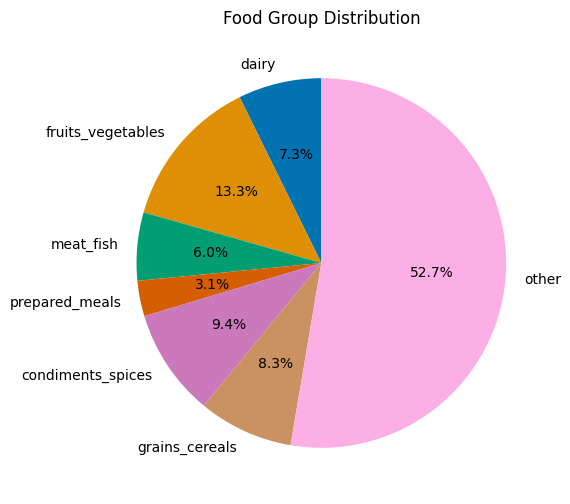

In [16]:
# Labels and sizes for the pie chart
labels = food_group_counts.index.tolist()
sizes = food_group_counts.values

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, startangle=90, autopct='%1.1f%%')
plt.title("Food Group Distribution")
plt.show()


## 6. Diet Pattern Analysis


Classify products into diet patterns and calculate compatibility scores.


In [17]:
# Define diet pattern classification
DIET_PATTERNS = {
    'vegan': {
        'include_keywords': [
            'vegan', 'plant-based', 'vegetable', 'fruit', 'tofu', 'tempeh', 'seitan',
            'soy', 'plant protein', 'legume', 'lentil', 'chickpea', 'quinoa', 'spinach',
            'broccoli', 'carrot', 'cucumber', 'lettuce', 'berry', 'orange', 'grape'
        ],
        'exclude_keywords': [
            'meat', 'chicken', 'beef', 'pork', 'fish', 'seafood', 'dairy', 'milk',
            'cheese', 'egg', 'butter', 'cream', 'yogurt', 'honey', 'bacon'
        ],
        'description': 'Plant-based foods excluding all animal products'
    },
    'vegetarian': {
        'include_keywords': [
            'vegetarian', 'veggie', 'plant', 'paneer', 'quinoa', 'legume', 'lentil',
            'chickpea', 'plant protein', 'egg', 'milk', 'cheese', 'yogurt', 'spinach',
            'broccoli', 'carrot', 'cucumber', 'lettuce', 'berry', 'orange', 'grape'
        ],
        'exclude_keywords': ['meat', 'chicken', 'beef', 'pork', 'fish', 'seafood'],
        'description': 'Plant-based and dairy products, excluding meat and fish'
    },
    'mediterranean': {
        'include_keywords': [
            'olive', 'fish', 'seafood', 'vegetable', 'fruit', 'nuts', 'whole grain',
            'hummus', 'falafel', 'legume', 'lentil', 'chickpea', 'bulgur', 'tabbouleh',
            'tomato', 'cucumber', 'onion', 'pepper', 'spinach', 'grape', 'orange'
        ],
        'exclude_keywords': ['processed', 'fried', 'fast food', 'sugary snacks'],
        'description': 'Traditional Mediterranean diet patterns'
    },
    'keto': {
        'include_keywords': [
            'high fat', 'low carb', 'keto', 'ketogenic', 'meat', 'fish', 'cheese',
            'nuts', 'avocado', 'coconut oil', 'almond flour', 'cauliflower rice',
            'zucchini noodles', 'butter', 'cream', 'egg', 'bacon', 'salmon', 'tuna'
        ],
        'exclude_keywords': [
            'sugar', 'bread', 'pasta', 'rice', 'potato', 'high-carb fruit', 'beer',
            'soda', 'juice', 'honey', 'oats'
        ],
        'description': 'High-fat, very low-carbohydrate foods'
    },
    'gluten_free': {
        'include_keywords': [
            'gluten-free', 'gluten free', 'rice', 'quinoa', 'corn', 'buckwheat',
            'amaranth', 'teff', 'sorghum', 'cassava', 'arrowroot', 'potato', 'oats'
        ],
        'exclude_keywords': [
            'wheat', 'barley', 'rye', 'bread', 'pasta', 'beer', 'malt', 'malt extract'
        ],
        'description': 'Foods without gluten-containing grains'
    },
    'dairy_free': {
        'include_keywords': [
            'dairy-free', 'dairy free', 'plant milk', 'coconut', 'almond', 'oat milk',
            'soy milk', 'cashew milk', 'rice milk', 'vegan cheese', 'ghee alternative'
        ],
        'exclude_keywords': [
            'milk', 'cheese', 'butter', 'cream', 'yogurt', 'yoghurt', 'paneer', 'ghee'
        ],
        'description': 'Foods without dairy products'
    }
}

def classify_hierarchy(row: pd.Series) -> list[str]:
    text_to_analyse = f"{row['product_name'].lower()} {row['categories'].lower()}"

    mapped_groups = []

    for group, keywords in CATEGORY_HIERARCHY.items():
        if any(keyword in text_to_analyse for keyword in keywords):
            mapped_groups.append(group)

    return mapped_groups if mapped_groups else ["other"]

def classify_diet_patterns(row: pd.Series) -> tuple[list[str], dict[str, int]]:
    text_to_analyse = f"{row['product_name'].lower()} {row['categories'].lower()}"

    diet_patterns = []
    diet_scores = {}

    for diet_name, diet_rules in DIET_PATTERNS.items():
        include_score = sum(1 for keyword in diet_rules['include_keywords']
                           if keyword in text_to_analyse)
        exclude_penalty = sum(1 for keyword in diet_rules['exclude_keywords']
                             if keyword in text_to_analyse)

        compatibility_score = include_score - exclude_penalty
        diet_scores[diet_name] = compatibility_score

        if compatibility_score > 0 and exclude_penalty == 0:
            diet_patterns.append(diet_name)

    if len(diet_patterns) == 0:
        diet_patterns.append("other")

    return diet_patterns, diet_scores

result = food_category_df.apply(classify_diet_patterns, axis=1, meta=(None, "object"))

food_category_df["diet_patterns"] = result.map(lambda x: x[0], meta=(None, "object"))
food_category_df["diet_scores"] = result.map(lambda x: x[1], meta=(None, "object"))


Explode `diet_patterns` column and compute value counts for diet pattern distribution.


In [18]:
exploded_diet_patterns = food_category_df.explode("diet_patterns")

with ProgressBar():
    diet_pattern_counts = exploded_diet_patterns["diet_patterns"].value_counts().compute()


[                                        ] | 0% Completed | 106.04 us

[########################################] | 100% Completed | 125.46 s


Generate a pie chart to visualise the distribution of diet patterns.


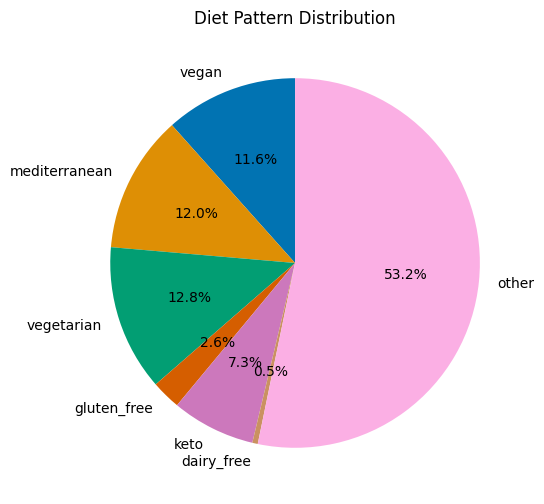

In [19]:
# Labels and sizes for the pie chart
labels = diet_pattern_counts.index.tolist()
sizes = diet_pattern_counts.values

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, startangle=90, autopct='%1.1f%%')
plt.title("Diet Pattern Distribution")
plt.show()


## 7. Important Food Features


Generate binary feature columns for meal types, food groups, and diet compatibility.


In [20]:
# 1. Binary features for meal types
for meal_type in MEAL_TYPE_KEYWORDS.keys():
    food_category_df[f'is_{meal_type}'] = food_category_df['meal_types'].apply(
        lambda x, meal_type=meal_type: meal_type in x, meta=(None, "bool")
    )

# 2. Binary features for food groups
for food_group in CATEGORY_HIERARCHY.keys():
    food_category_df[f'is_{food_group}'] = food_category_df['food_groups'].apply(
        lambda x, food_group=food_group: food_group in x, meta=(None, "bool")
    )

# 3. Binary features for diet compatibility
for diet_pattern in DIET_PATTERNS.keys():
    food_category_df[f'is_{diet_pattern}_compatible'] = food_category_df['diet_patterns'].apply(
        lambda x, diet_pattern=diet_pattern: diet_pattern in x, meta=(None, "bool")
    )


Extract and compute the sum of binary feature columns starting with `is_`.


In [21]:
# Extract all columns starting with "is_"
is_columns = [col for col in food_category_df.columns if col.startswith("is_")]

# Compute the sum of True values for each column
with ProgressBar():
    is_column_sums = food_category_df[is_columns].sum().compute()


[########################################] | 100% Completed | 127.68 s


Generate a bar chart showing the distribution of important food feature.


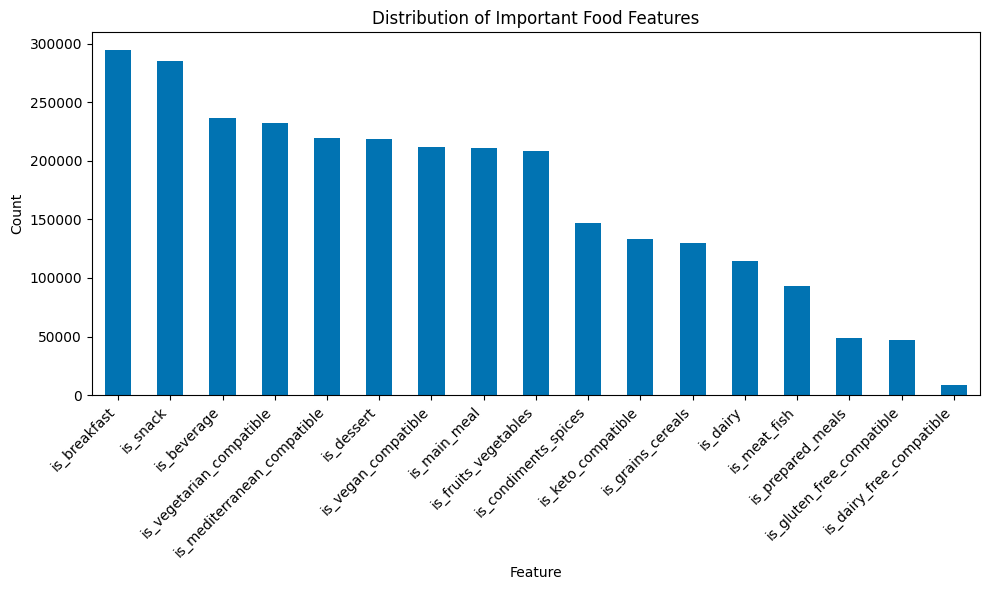

In [22]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
is_column_sums.sort_values(ascending=False).plot(kind="bar")
plt.title("Distribution of Important Food Features")
plt.ylabel("Count")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Create product features dataset and save into `data\product_features`.


In [23]:
product_features_df = food_category_df.drop(
    columns=["product_lang", "categories", "meal_types", "food_groups", "diet_patterns", "diet_scores"]
)

with ProgressBar():
    product_features_df.to_parquet("data/product_features", engine="pyarrow", write_index=True, overwrite=True)


[########################################] | 100% Completed | 126.46 s


Load the `data/product_features` dataset.


In [24]:
product_features_df = dd.read_parquet("data/product_features", engine="pyarrow", dtype_backend="pyarrow")


View top 3 rows in `product_features_df`.


In [25]:
product_features_df.head(3)


,code,product_name,image_key,image_rev,is_breakfast,is_main_meal,is_snack,is_dessert,is_beverage,is_dairy,...,is_grains_cereals,is_fruits_vegetables,is_condiments_spices,is_prepared_meals,is_vegan_compatible,is_vegetarian_compatible,is_mediterranean_compatible,is_keto_compatible,is_gluten_free_compatible,is_dairy_free_compatible
0,0000101209159,Véritable pâte à tartiner noisettes chocolat noir,front_fr,4,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0000140323687,Madeleine Framboise,front_fr,4,True,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,0000141013129,Croissants margarine,front_fr,4,True,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
